In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Прочитайте данные (переменную назовите 'df')
df = pd.read_csv('data1.csv')

# Вывести несколько первых строк таблицы данных
print(df.head())

         Дата  Склад Контрагент Номенклатура  Количество
0  2018-01-04      1  address_0    product_0           4
1  2018-01-04      1  address_0    product_1           4
2  2018-01-04      1  address_0    product_2           5
3  2018-01-04      1  address_0    product_3          10
4  2018-01-04      1  address_0    product_4           2


Проверяем формат столбцов

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301355 entries, 0 to 301354
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Дата          301355 non-null  object
 1   Склад         301355 non-null  int64 
 2   Контрагент    301355 non-null  object
 3   Номенклатура  301355 non-null  object
 4   Количество    301355 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.5+ MB


Сразу переведем столбец "Дата" в правильный формат

In [19]:
df['Дата'] = pd.to_datetime(df['Дата'])
print(df['Дата'].dtype)

datetime64[ns]


Сгруппируйте данные по дате, посчитайте количество продаж

In [22]:
grouped_df = df.groupby('Дата').size().reset_index(name='Количество продаж')

Вывести несколько первых строк сгруппированных данных

In [25]:
grouped_df.head

<bound method NDFrame.head of           Дата  Количество продаж
0   2018-01-04               1840
1   2018-01-05               1301
2   2018-01-06               1306
3   2018-01-07               1322
4   2018-01-09               1719
..         ...                ...
200 2018-08-26               1462
201 2018-08-28               1731
202 2018-08-29               1497
203 2018-08-30               1445
204 2018-08-31               1366

[205 rows x 2 columns]>

Нарисуйте график продаж у `grouped_df`

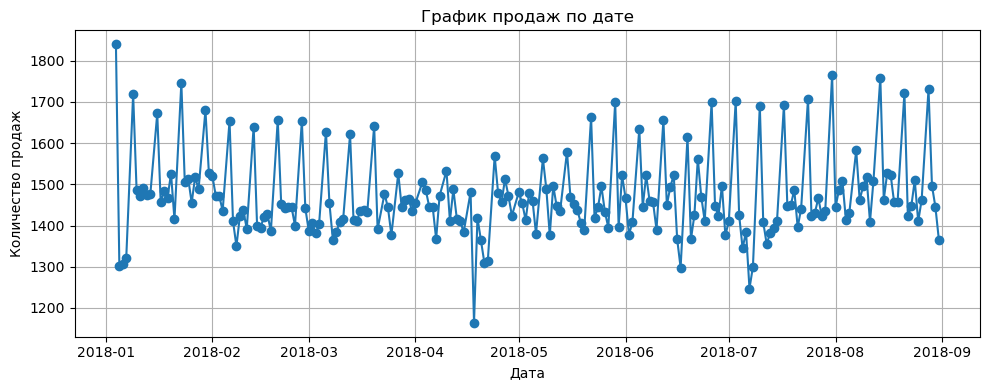

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(grouped_df['Дата'], grouped_df['Количество продаж'], marker='o')
plt.title('График продаж по дате')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.grid(True)
plt.tight_layout()
plt.show()

Опишите что вы видите на графике. Ваша задача - максимально описать график

#### На графике видны периодические скочки продаж. Что может говорить о определенных днях недели например когда продаж много
#### Максимальное значение продажи равно примерно 1850(в начале Января) а минимальный около 1150(в середине Мая)
#### Однако основная масса лежит в пределах около 1370-1500 продаж
#### Данные выглядят довольно стабильно что говорит о стабильном спросе но без определенной зависимости от времен года или месяцев

Найдите строку, у которой максимальный выброс по количеству продаж (нужно найти выброс у `df`)

In [33]:
q1 = df['Количество'].quantile(0.25)
q3 = df['Количество'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['Количество'] < lower_bound) | (df['Количество'] > upper_bound)]

max_outlier_row = outliers.loc[outliers['Количество'].idxmax()]

print(max_outlier_row)

Дата            2018-06-28 00:00:00
Склад                             1
Контрагент              address_208
Номенклатура              product_0
Количество                      200
Name: 218822, dtype: object


Найдите топовый товар по продажам по средам за июнь, июль, август у 3 склада

In [36]:
filtered_df = df[
    (df['Склад'] == 3) &
    (df['Дата'].dt.month.isin([6, 7, 8])) &
    (df['Дата'].dt.weekday == 2)
]

top_product = filtered_df.groupby('Номенклатура')['Количество'].sum().idxmax()

max_quantity = filtered_df.groupby('Номенклатура')['Количество'].sum().max()

print(f'Топовый товар по продажам по средам за летние месяцы на складе 3: {top_product} (продано {max_quantity} шт.)')

Топовый товар по продажам по средам за летние месяцы на складе 3: product_1 (продано 2267 шт.)


Скачайте данные по погоде с https://rp5.ru/Архив_погоды_в_Астане (скачайте исходные данные, и далее преобразуйте так, чтобы мы имели Дату и Среднюю температуру за день), объедините таблицу температуры с `grouped_df`, и нарисуйте график `y=['Количество продаж', 'T']`, где Т это температура. А также отдельно график температуры.

In [39]:
weather_df = pd.read_csv(
    'weather01.csv',
    sep=",",
    names=["Дата", "T"],
    skiprows=1,
    usecols=[0, 1] 
)
weather_df.dropna(inplace=True)

weather_df["Дата"] = pd.to_datetime(weather_df["Дата"])
weather_df["T"] = weather_df["T"].str.replace(";", "", regex=False).astype(float)
weather_df = weather_df.groupby("Дата", as_index=False).agg({"T": "mean"})

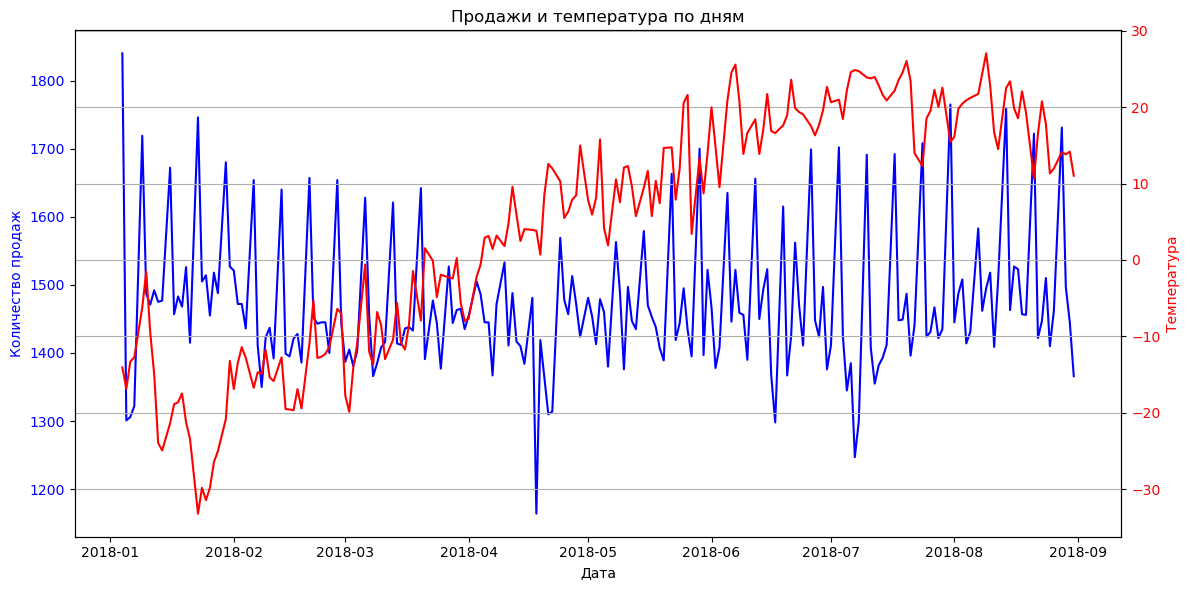

In [43]:
merged_df = pd.merge(grouped_df, weather_df, on="Дата", how="inner")
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_df["Дата"], merged_df["Количество продаж"], label="Количество продаж", color="blue")
ax1.set_xlabel("Дата")
ax1.set_ylabel("Количество продаж", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(merged_df["Дата"], merged_df["T"], label="Температура", color="red")
ax2.set_ylabel("Температура", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Продажи и температура по дням")
fig.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

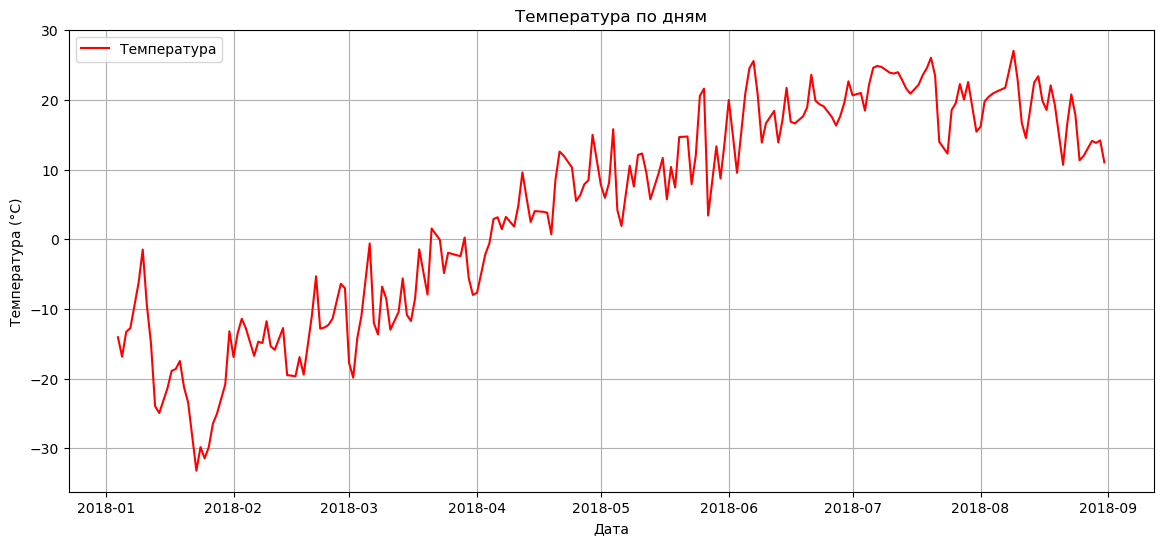

In [99]:
plt.figure(figsize=(14, 6))
plt.plot(merged_df["Дата"], merged_df["T"], color='red', label='Температура')
plt.title("Температура по дням")
plt.xlabel("Дата")
plt.ylabel("Температура (°C)")
plt.legend()
plt.grid(True)
plt.show()